In [1]:
!pip install transformers
!pip install transformers datasets
!pip install torchinfo
!pip uninstall accelerate transformers
!pip install accelerate transformers[torch]

Found existing installation: transformers 4.35.2
Uninstalling transformers-4.35.2:
  Would remove:
    /usr/local/bin/transformers-cli
    /usr/local/lib/python3.10/dist-packages/transformers-4.35.2.dist-info/*
    /usr/local/lib/python3.10/dist-packages/transformers/*
Proceed (Y/n)? y
y
y
  Successfully uninstalled transformers-4.35.2
y
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 22.6 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from sklearn.metrics import f1_score,accuracy_score,confusion_matrix
from sklearn.model_selection import train_test_split
from transformers import TrainingArguments
from datasets import load_dataset
from torchinfo import summary
from transformers import pipeline
from transformers import AutoTokenizer

In [4]:
df=pd.read_csv('/content/drive/MyDrive/Sentiment Analysis/AirlineTweets.csv')
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [5]:
print(set(df['airline_sentiment']))
len(df)

{'positive', 'negative', 'neutral'}


14640

In [6]:
df=df[['airline_sentiment','text']].copy()
df.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


<Axes: >

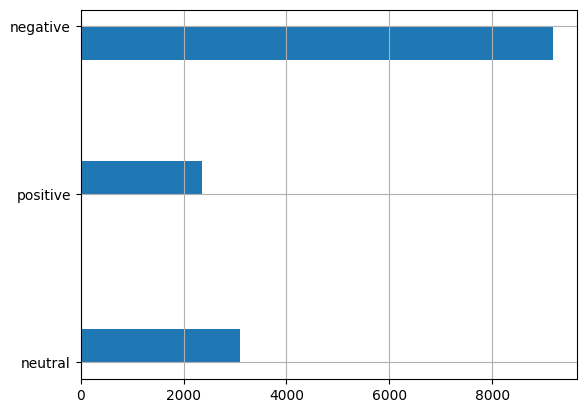

In [7]:
df['airline_sentiment'].hist(orientation='horizontal')

In [8]:
target_map={'positive':1,'negative':0,'neutral':2}
df['target']=df['airline_sentiment'].map(target_map)
df.head()

,airline_sentiment,text,target
0,neutral,@VirginAmerica What @dhepburn said.,2
1,positive,@VirginAmerica plus you've added commercials t...,1
2,neutral,@VirginAmerica I didn't today... Must mean I n...,2
3,negative,@VirginAmerica it's really aggressive to blast...,0
4,negative,@VirginAmerica and it's a really big bad thing...,0


In [9]:
df2=df[['text','target']]
df2.head()

,text,target
0,@VirginAmerica What @dhepburn said.,2
1,@VirginAmerica plus you've added commercials t...,1
2,@VirginAmerica I didn't today... Must mean I n...,2
3,@VirginAmerica it's really aggressive to blast...,0
4,@VirginAmerica and it's a really big bad thing...,0


In [10]:
df2.columns=['sentence','label']
df2.to_csv('data.csv',index=None)
!head data.csv

sentence,label
@VirginAmerica What @dhepburn said.,2
@VirginAmerica plus you've added commercials to the experience... tacky.,1
@VirginAmerica I didn't today... Must mean I need to take another trip!,2
"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",0
@VirginAmerica and it's a really big bad thing about it,0
"@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.
it's really the only bad thing about flying VA",0
"@VirginAmerica yes, nearly every time I fly VX this “ear worm” won’t go away :)",1
"@VirginAmerica Really missed a prime opportunity for Men Without Hats parody, there. https://t.co/mWpG7grEZP",2


In [11]:
raw_dataset=load_dataset('csv',data_files='data.csv')
raw_dataset

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 14640
    })
})

In [12]:
split=raw_dataset['train'].train_test_split(test_size=0.3,seed=42)
split

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 10248
    })
    test: Dataset({
        features: ['sentence', 'label'],
        num_rows: 4392
    })
})

In [13]:
checkpoint='distilbert-base-cased'
tokenizer=AutoTokenizer.from_pretrained(checkpoint)
def tokenize_fn(batch):
  return tokenizer(batch['sentence'],truncation=True)
tokenized_datasets=split.map(tokenize_fn,batched=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Map:   0%|          | 0/10248 [00:00<?, ? examples/s]

Map:   0%|          | 0/4392 [00:00<?, ? examples/s]

In [14]:
from transformers import AutoModelForSequenceClassification,AutoConfig,Trainer,TrainingArguments
config=AutoConfig.from_pretrained(checkpoint)
print('config: ',config)
print(config.id2label)
print(config.label2id)

config.id2label={v:k for k,v in target_map.items()}
config.label2id=target_map

model=AutoModelForSequenceClassification.from_pretrained(
    checkpoint,
    config=config
)

config:  DistilBertConfig {
  "_name_or_path": "distilbert-base-cased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.37.2",
  "vocab_size": 28996
}

{0: 'LABEL_0', 1: 'LABEL_1'}
{'LABEL_0': 0, 'LABEL_1': 1}


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
summary(model)

Layer (type:depth-idx)                                  Param #
DistilBertForSequenceClassification                     --
├─DistilBertModel: 1-1                                  --
│    └─Embeddings: 2-1                                  --
│    │    └─Embedding: 3-1                              22,268,928
│    │    └─Embedding: 3-2                              393,216
│    │    └─LayerNorm: 3-3                              1,536
│    │    └─Dropout: 3-4                                --
│    └─Transformer: 2-2                                 --
│    │    └─ModuleList: 3-5                             42,527,232
├─Linear: 1-2                                           590,592
├─Linear: 1-3                                           2,307
├─Dropout: 1-4                                          --
Total params: 65,783,811
Trainable params: 65,783,811
Non-trainable params: 0

In [16]:
def compute_metrics(logits_and_labels):
  logits,labels=logits_and_labels
  predictions=np.argmax(logits,axis=-1)
  acc=np.mean(predictions==labels)
  f1=f1_score(labels,predictions,average='macro')
  return {'accuracy':acc,'f1':f1}

In [17]:
training_args = TrainingArguments(
    output_dir='training_dir',
    evaluation_strategy='epoch',
    save_strategy='epoch',
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,

)

In [18]:

trainer=Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['test'],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.534000,0.431240,0.827869,0.765740
2,0.355400,0.500188,0.833789,0.770676
3,0.241800,0.718947,0.829918,0.776245
4,0.095700,0.822930,0.835610,0.781553
5,0.052600,0.909267,0.835838,0.781329


TrainOutput(global_step=3205, training_loss=0.22788906394970398, metrics={'train_runtime': 359.4781, 'train_samples_per_second': 142.54, 'train_steps_per_second': 8.916, 'total_flos': 646793957399760.0, 'train_loss': 0.22788906394970398, 'epoch': 5.0})

In [30]:
!ls training_dir
#this shows the checkpoints refering to epochs accuracy

checkpoint-1282  checkpoint-1923  checkpoint-2564  checkpoint-3205  checkpoint-641  runs


In [31]:
#use checkpoint which performed earlier during training
savedmodel=pipeline('text-classification',
                    model='training_dir/checkpoint-3205',
                    )

In [33]:
split['test']

Dataset({
    features: ['sentence', 'label'],
    num_rows: 4392
})

In [34]:
test_pred=savedmodel(split['test']['sentence'])

In [40]:
test_pred

[{'label': 'positive', 'score': 0.989972710609436},
 {'label': 'positive', 'score': 0.9970158338546753},
 {'label': 'negative', 'score': 0.9976085424423218},
 {'label': 'positive', 'score': 0.9968365430831909},
 {'label': 'neutral', 'score': 0.99817955493927},
 {'label': 'negative', 'score': 0.9993844032287598},
 {'label': 'neutral', 'score': 0.997771143913269},
 {'label': 'neutral', 'score': 0.9982800483703613},
 {'label': 'positive', 'score': 0.9944732785224915},
 {'label': 'negative', 'score': 0.9994459748268127},
 {'label': 'negative', 'score': 0.9994457364082336},
 {'label': 'negative', 'score': 0.9993395209312439},
 {'label': 'positive', 'score': 0.9920663833618164},
 {'label': 'negative', 'score': 0.9995162487030029},
 {'label': 'neutral', 'score': 0.9974038004875183},
 {'label': 'neutral', 'score': 0.985684871673584},
 {'label': 'neutral', 'score': 0.5772081017494202},
 {'label': 'negative', 'score': 0.9992389678955078},
 {'label': 'negative', 'score': 0.9973188042640686},
 {'l

In [47]:
# Example sentence
sentence = "This is an example sentence."
# Make the prediction
prediction = savedmodel(sentence)
prediction

[{'label': 'negative', 'score': 0.9939737915992737}]

In [40]:
https://drive.google.com/drive/folders/1gdvFUarIUJmFsQNE24LaRNRBLU6-II5m